#### Load libraries

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(data.table))
suppressMessages(library(dendextend))
suppressMessages(library(reshape2))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(gridExtra))
source("../0_support-files//theme_CRP-MISC.R")

###----------------------------------

PVAL_THRESH = 0.05
LOGFC_THRESH = 0.01

###----------------------------------

annotation <- fread(file="../0_support-files/gencode.biotype.name.key.tsv")

#### Load Functions

In [2]:
colLab<<-function(n,metadata){
    if(is.leaf(n)){
        
#         print(attributes(n)$label)
        
        #I take the current attributes
        a=attributes(n)
        
        #I deduce the line in the original data, and so the treatment and the specie.
        ligne=match(attributes(n)$label,rownames(metadata))
        Diagnosis=metadata[ligne,]$Diagnosis;
            if(Diagnosis=="COVID-19"){col_diag="#F0484E"};if(Diagnosis=="MIS-C"){col_diag="#5CB2EB"};if(Diagnosis=="Control_Non-inflammatory"){col_diag="#FBE77C"};if(Diagnosis=="Control_Inflammatory"){col_diag="purple"}
        #Modification of leaf attribute
        attr(n,"nodePar")<-c(a$nodePar,list(cex=1.5,lab.cex=1,pch=15,col=col_diag,lab.col=col_diag,lab.font=1,lab.cex=1))
        }
    return(n)
}


get_gene_id <- function(X,annotation){
    return(gsub(".*_","",X))
    # return(annotation[which(annotation$gene_name == X),]$gene_id)
    }

get_dend <- function(IDS,sig_genes,meta,ftcounts){
    
    metadata <- meta 
    rownames(metadata) <- metadata$PTID
    metadata <- metadata[IDS,]
    metadata <- metadata %>% select(Diagnosis, severity)

    ###----------------------------------
    ## Subset count matrix
    mat <- data.frame(ftcounts)[,IDS] %>% 
            filter(row.names(ftcounts) %in% all_of(sig_genes)) %>% 
            as.matrix()

    mat <- t(scale(t(mat)))

    ###----------------------------------
    ## Perform clustering

    h <- hclust(as.dist(1 - cor(mat, method = "pearson", use = 'pairwise.complete.obs')))
#     h <- hclust(as.dist(mat))

    dend <- as.dendrogram(h)

    dendL <- dendrapply(dend, colLab,metadata)

    return(dendL)
}


make_dend_list <- function(cf_tmp_rds, wb_tmp_res, 
                           cf_meta, wb_meta,
                           cf_ftcounts,wb_ftcounts,
                           PVAL_THRESH = PVAL_THRESH, LOGFC_THRESH = LOGFC_THRESH,N=0){
    
    #----------------------------------------
    ## Cell-free
    IDS_cf <- colnames(cf_tmp_rds[['dds']])
    if (N>0){IDS_cf <- sample(IDS_cf,N)}

    PTIDs <- cf_meta %>% filter(cfrna_sample_id %in% all_of(IDS_cf)) %>% pull(PTID)

    sig_genes_cf <- data.frame(cf_tmp_rds[['res']]) %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% rownames()
    cf_dendL = get_dend(PTIDs,sig_genes_cf,cf_meta,cf_ftcounts)

    #----------------------------------------
    ## Whole blood
    wb_tmp_res$ensmbl <- gsub("_.*","",wb_tmp_res$GeneID)

    sig_genes_wb <- wb_tmp_res %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% pull(ensmbl)
    wb_dendL = get_dend(PTIDs,sig_genes_wb,wb_meta,wb_ftcounts)

    return(dendlist(cf_dendL,wb_dendL))
}


get_pval <- function(dendlist,the_cor,R){
    
    set.seed(42)
    
    cor_bakers_gamma_results <- numeric(R)
    
    d1 <- dendlist[[1]]
    d2 <- dendlist[[2]]
    
    for(i in 1:R) {
       dend_mixed <- sample.dendrogram(d2, replace = FALSE)
       cor_bakers_gamma_results[i] <- cor_bakers_gamma(d1, dend_mixed)
    }
    
    if(sum(the_cor < cor_bakers_gamma_results)==0){return("ALL BELOW")}
    
    pval <- sum(the_cor < cor_bakers_gamma_results)/ R
                  
    return(pval)

}

get_conf <- function(dendlist,the_cor,R){

    set.seed(42)
    
    dend1 <- dendlist[[1]]
    dend2 <- dendlist[[2]]

    dend1_labels <- labels(dend1)
    dend2_labels <- labels(dend2)
    cor_bakers_gamma_results <- numeric(R)
    
    for(i in 1:R) {
       sampled_labels <- sample(dend1_labels, replace = TRUE)
       # members needs to be fixed since it will be later used in nleaves
       dend_mixed1 <- sample.dendrogram(dend1, 
                                        dend_labels=dend1_labels,
                                        fix_members=TRUE,fix_order=TRUE,fix_midpoint=FALSE,
                                        replace = TRUE, sampled_labels=sampled_labels
                                          )
       dend_mixed2 <- sample.dendrogram(dend2, dend_labels=dend2_labels,
                                        fix_members=TRUE,fix_order=TRUE,fix_midpoint=FALSE,
                                        replace = TRUE, sampled_labels=sampled_labels
                                          )                                    
       cor_bakers_gamma_results[i] <- cor_bakers_gamma(dend_mixed1, dend_mixed2, warn = FALSE)
    }


    CI95 <- quantile(cor_bakers_gamma_results, probs=c(.025,.975))
    
    return(CI95)
}

#### Load outputs

In [3]:
cf_covid_cntrl <- readRDS("./subset_CF/daa_output/covid-control_paired.rds")
cf_misc_cntrl <- readRDS("./subset_CF/daa_output/misc-control_paired.rds")
cf_misc_covid <- readRDS("./subset_CF/daa_output/misc-covic_paired.rds")

wb_covid_cntrl <- read.delim("./subset_WB/tables/wb_covid-cntrl_paired_DESeq.tsv")
wb_misc_cntrl <- read.delim("./subset_WB/tables/wb_misc-cntrl_paired_DESeq.tsv")
wb_misc_covid <- read.delim("./subset_WB/tables/wb_misc-covid_paired_DESeq.tsv")


## PAIRED SAMPLES

paired <- read.delim("../1_sample-data/paired_sample_key.tsv") %>%
    filter(!is.na(cfrna_sample_id) & !is.na(wbrna_sample_id))


## FILTER

globin = c('HBA1','HBA2','HBB','HBBP1','HBD',
     'HBE1','HBG1','HBG2','HBM','HBQ1',
     'HBZ','HBZP1')
globin = annotation %>% filter(gene_name %in% all_of(globin)) %>% pull(gene_id) 

gene.list <- read.delim("../0_support-files/genelist.hs.tsv",col.names = c("type,","ENSMBL","gene_symbol"))

#### Load Whole Blood

In [4]:
#------------------------
## READ OUTPUTS

wb_meta <- read.csv("../1_sample-data/STable7_wbrna-samples.csv") %>% 
    filter(wbrna_sample_id %in% all_of(paired$wbrna_sample_id))

wb_meta = wb_meta[!duplicated(wb_meta$PTID),]

wb_ftcounts <- read.delim("../1_sample-data/wbrna_ftcounts.txt") %>% 
    rename(gene_id = X) %>% 
    mutate(gene_id = gsub("\\_.*","",gene_id)) %>%
    distinct(gene_id, .keep_all = TRUE) %>%
    column_to_rownames(var = "gene_id")

wb_ftcounts <- wb_ftcounts[,wb_meta$wbrna_sample_id]
colnames(wb_ftcounts) <- wb_meta$PTID

#------------------------
## FILTER

gene.ids_wb <- gsub("\\..*","",rownames(wb_ftcounts))
exclude.idx_wb <- gene.ids_wb %in% c(gene.list[,2], globin)
wb_ftcounts = wb_ftcounts[!exclude.idx_wb,] 
wb_ftcounts <- wb_ftcounts[,colSums(wb_ftcounts) > 0]

#------------------------
## NORMALIZE

wb_ftcounts <- edgeR::cpm(wb_ftcounts)

#### Load Cell-Free

In [5]:
#------------------------
## READ OUTPUTS

cf_meta <-read.csv("../1_sample-data/STable6_cfrna-samples.csv") %>%
    filter(cfrna_sample_id %in% all_of(paired$cfrna_sample_id))

cf_meta = cf_meta[!duplicated(cf_meta$PTID),]


cf_ftcounts <- read.delim("../1_sample-data/cfrna_ftcounts.txt") %>%
    rename(gene_id = Geneid) %>% 
    mutate(gene_id = gsub("\\_.*","",gene_id)) %>%
    distinct(gene_id, .keep_all = TRUE) %>%
    column_to_rownames(var = "gene_id")

cf_ftcounts <- cf_ftcounts[,cf_meta$cfrna_sample_id]
colnames(cf_ftcounts) <- cf_meta$PTID

#------------------------
## FILTER

gene.ids_cf <- gsub("\\..*","",rownames(cf_ftcounts))
exclude.idx_cf <- gene.ids_cf %in% c(gene.list[,2], globin)
cf_ftcounts = cf_ftcounts[!exclude.idx_cf,] 


#------------------------
## NORMALIZE
cf_ftcounts <- edgeR::cpm(cf_ftcounts)


----
----
---
## Universal Code

In [6]:
PVAL_THRESH = 0.05
LOGFC_THRESH = 1

#### __MIS-C and COVID-19__

In [7]:
###----------------------------------
# MIS-C and COVID
dendlist <- make_dend_list(cf_misc_covid, wb_misc_covid, 
                           cf_meta, wb_meta,
                           cf_ftcounts,wb_ftcounts,
                           PVAL_THRESH = PVAL_THRESH, LOGFC_THRESH = LOGFC_THRESH)

bg_cor <- cor_bakers_gamma(dendlist[[1]],dendlist[[2]])
pval <- get_pval(dendlist,bg_cor,1000)

print(bg_cor)
print(pval)

HEIGHT = 1
WIDTH = 3

pdf(file="plots/panelC_misc-covid.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

dendlist %>% 
    tanglegram(intersecting= TRUE,color_lines = "black",
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2)

dev.off()

[1] 0.2130335
[1] 0.002


png 
  2

#### __MIS-C and CONTROL__

In [8]:
###----------------------------------
# MIS-C and Control
dendlist <- make_dend_list(cf_misc_cntrl, wb_misc_cntrl, 
                           cf_meta, wb_meta,
                           cf_ftcounts,wb_ftcounts,
                           PVAL_THRESH = PVAL_THRESH, LOGFC_THRESH = LOGFC_THRESH)

bg_cor <- cor_bakers_gamma(dendlist[[1]],dendlist[[2]])
pval <- get_pval(dendlist,bg_cor,1000)

print(bg_cor)
print(pval)


pdf(file="plots/panelC_misc-control.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

dendlist %>% 
    tanglegram(intersecting= TRUE,color_lines = "black",
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2)
dev.off()



[1] 0.5933907
[1] "ALL BELOW"


png 
  2

#### __COVID-19 and CONTROL__

In [9]:
###----------------------------------
# COVID and Control
dendlist <- make_dend_list(cf_covid_cntrl, wb_covid_cntrl, 
                           cf_meta, wb_meta,
                           cf_ftcounts,wb_ftcounts,
                           PVAL_THRESH = PVAL_THRESH, LOGFC_THRESH = LOGFC_THRESH)

bg_cor <- cor_bakers_gamma(dendlist[[1]],dendlist[[2]])
pval <- get_pval(dendlist,bg_cor,1000)

print(bg_cor)
print(pval)


pdf(file="plots/panelC_covid-control.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

dendlist %>% 
    tanglegram(intersecting= TRUE,color_lines = "black",
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2)
dev.off()

[1] 0.9559779
[1] "ALL BELOW"


png 
  2

---
---
---
# Simulation results

In [4]:
sim_df <- read.delim("./simulation_bakers_gamma.tsv")
colnames(sim_df) <- c("MIS-C_vs_COVID-19","MIS-C_vs_Control")
sim_df_m <- melt(sim_df)
sim_df_m %>% head()

No id variables; using all as measure variables



,variable,value
,<fct>,<dbl>
1,MIS-C_vs_COVID-19,0.2975010
2,MIS-C_vs_COVID-19,0.3866374
3,MIS-C_vs_COVID-19,0.5541144
4,MIS-C_vs_COVID-19,0.4965362
5,MIS-C_vs_COVID-19,0.3079767
6,MIS-C_vs_COVID-19,0.5219729


---
#### _pvalues_

In [5]:
misc_cntrl_sim <- sim_df$`MIS-C_vs_Control`
misc_cntrl_all <- 0.6
pval = sum(misc_cntrl_all <= misc_cntrl_sim)/length(misc_cntrl_sim) *2
print(pval)

misc_covid_sim <- sim_df$`MIS-C_vs_COVID-19`
misc_covid_all <- 0.22
pval = sum(misc_covid_all >= misc_covid_sim)/length(misc_covid_sim) *2
print(pval)

[1] 0.848
[1] 0.398


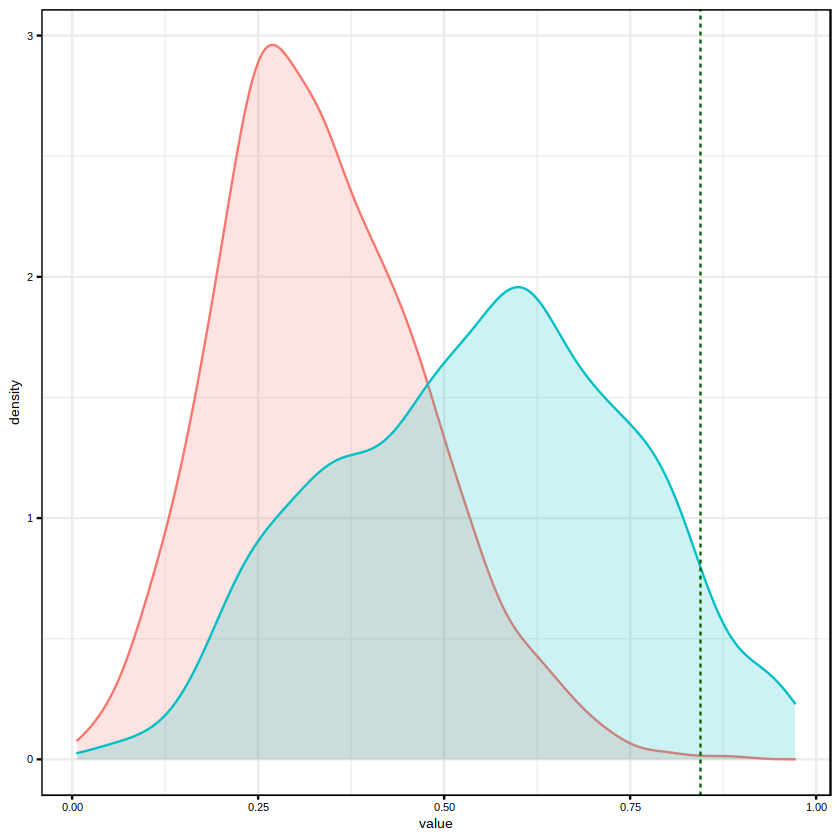

In [15]:
sim_df_m %>% 
    ggplot(aes(x=value,color=variable,fill=variable)) + 
    geom_density(alpha = 0.2) +
    geom_vline(xintercept=0.8450, color = "dark green", lty=2) + 
    theme_prevail() + theme(legend.position = "none")

In [4]:

pdf(file="plots/entangle_simulations.pdf",
        width=1.8,height=1.6, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

sim_df_m %>% 
    ggplot(aes(x=value,color=variable,fill=variable)) + 
    geom_density(alpha = 0.2) +
    geom_vline(xintercept=0.8450, color = "dark green", lty=2) + 
    theme_alex() + theme(legend.position = "none")

dev.off()

png 
  2

---
---
---
## SUBSET FOR FIG1

In [12]:
tmp <- cf_misc_covid
dds <- tmp[['dds']]
tmp[['dds']] <- dds[,colnames(dds) %in% c('prevail_cu_cfrna_293','prevail_cu_cfrna_298','prevail_cu_cfrna_192','prevail_cu_cfrna_235','prevail_cu_cfrna_236')]

[1] "prevail_cu_cfrna_293" "prevail_cu_cfrna_298" "prevail_cu_cfrna_301"
 [4] "prevail_cu_cfrna_308" "prevail_cu_cfrna_300" "prevail_cu_cfrna_304"
 [7] "prevail_cu_cfrna_305" "prevail_cu_cfrna_81"  "prevail_cu_cfrna_82" 
[10] "prevail_cu_cfrna_83"  "prevail_cu_cfrna_307" "prevail_cu_cfrna_313"
[13] "prevail_cu_cfrna_303" "prevail_cu_cfrna_310" "prevail_cu_cfrna_309"
[16] "prevail_cu_cfrna_290" "prevail_cu_cfrna_108" "prevail_cu_cfrna_294"
[19] "prevail_cu_cfrna_287" "prevail_cu_cfrna_282" "prevail_cu_cfrna_284"
[22] "prevail_cu_cfrna_285" "prevail_cu_cfrna_292" "prevail_cu_cfrna_24" 
[25] "prevail_cu_cfrna_296" "prevail_cu_cfrna_299" "prevail_cu_cfrna_42" 
[28] "prevail_cu_cfrna_171" "prevail_cu_cfrna_152" "prevail_cu_cfrna_174"
[31] "prevail_cu_cfrna_181" "prevail_cu_cfrna_183" "prevail_cu_cfrna_175"
[34] "prevail_cu_cfrna_179" "prevail_cu_cfrna_182" "prevail_cu_cfrna_191"
[37] "prevail_cu_cfrna_192" "prevail_cu_cfrna_235" "prevail_cu_cfrna_236"

class: DESeqDataSet 
dim: 56634 4 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(56634): ENSG00000223972.5 ENSG00000227232.5 ...
  ENSG00000278625.1 ENSG00000277374.1
rowData names(26): gene_id gene_name ... maxCooks replace
colnames(4): prevail_cu_cfrna_293 prevail_cu_cfrna_298
  prevail_cu_cfrna_235 prevail_cu_cfrna_236
colData names(62): unique_sample_id PTID ... sizeFactor replaceable

In [27]:
###----------------------------------
# MIS-C and COVID
set.seed(42)
tmp <- cf_misc_covid
dds <- tmp[['dds']]
keepers <- sample(colnames(dds),8)
tmp[['dds']] <- dds[,colnames(dds) %in% keepers]

dendlist <- make_dend_list(tmp, wb_misc_covid, 
                           cf_meta, wb_meta,
                           cf_ftcounts,wb_ftcounts,
                           PVAL_THRESH = PVAL_THRESH, LOGFC_THRESH = LOGFC_THRESH)

bg_cor <- cor_bakers_gamma(dendlist[[1]],dendlist[[2]])
pval <- get_pval(dendlist,bg_cor,1000)

print(bg_cor)
print(pval)

HEIGHT = 1
WIDTH = 1

pdf(file="plots/entangle_FIG1.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

dendlist %>% 
    tanglegram(intersecting= TRUE,
               color_lines = "black",
            margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 1,
               edge.lwd = 1,
             margin_top=0,
             margin_bottom = 0)

dev.off()

[1] 0.1386981
[1] 0.219


png 
  2

In [31]:
pdf(file="plots/entangle_FIG1.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

dendlist %>% 
    tanglegram(intersecting= TRUE,
               color_lines = "black",
            margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 1,
               edge.lwd = 1,
             margin_top=0,
             margin_bottom = 0)

dev.off()

png 
  2

---
---
---
# OLD

---
---
---
# MIS-C vs COVID-19

#### Read in data and create dendograms

In [40]:
# MISC vs COVID

cf_tmp_rds <- cf_misc_covid
wb_tmp_res <- wb_misc_covid

#----------------------------------------
## Cell-free
IDS_cf <- colnames(cf_tmp_rds[['dds']])

sig_genes_cf <- data.frame(cf_tmp_rds[['res']]) %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% rownames()
cf_dendL = get_dend(IDS_cf,sig_genes_cf,cf_meta,cf_ftcounts)

#----------------------------------------
## Whole blood
wb_tmp_res$ensmbl <- lapply(wb_tmp_res$gene,get_gene_id,annotation)

cf_pt_dates <- cf_meta %>% filter(cfrna_sample_id %in% all_of(IDS_cf)) %>% pull(PTID_DATE)

IDS_wb <- wb_meta %>% 
    filter(PTID_DATE %in% all_of(cf_pt_dates)) %>% 
    pull(SEQ_ID..UCSFonly.)

sig_genes_wb <- wb_tmp_res %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% pull(ensmbl)
wb_dendL = get_dend(IDS_wb,sig_genes_wb,wb_meta,wb_ftcounts)

In [52]:
K_clus = 1

cf_d <- cf_dendL %>% ladderize %>%  set("branches_k_color", value = 1:K_clus, k = K_clus)
wb_d <- wb_dendL %>% ladderize %>%   set("branches_k_color", value = 1:K_clus, k = K_clus)

cf_d <- cf_dendL %>% set("branches_k_color", value = 1:K_clus, k = K_clus)
wb_d <- wb_dendL %>% set("branches_k_color", value = 1:K_clus, k = K_clus)


## Get labels and clusters
cf_d_grps <- cf_d  %>% cutree(k=K_clus)
cf_d_labs <- cf_d %>% labels
cf_d_grps <- cf_d_grps[cf_d_labs]

wb_d_grps <- wb_d  %>% cutree(k=K_clus)
wb_d_labs <- wb_d %>% labels
wb_d_grps <- wb_d_grps[wb_d_labs]

# m_cntrl_grps = ifelse(m_cntrl_grps == 2,3,ifelse(m_cntrl_grps == 1,2,ifelse(m_cntrl_grps == 3,1,4)))


FINAL_COLORS <- c()
for (n in names(cf_d_grps)){
    if (n %in% names(wb_d_grps)){
    if (wb_d_grps[[n]] != wb_d_grps[[n]]){
        FINAL_COLORS <- c(FINAL_COLORS,"grey")
    } else{FINAL_COLORS <- c(FINAL_COLORS,cf_d_grps[[n]])} }
    
}

# FINAL_COLORS <- ifelse(FINAL_COLORS == '4','2',ifelse(FINAL_COLORS == '1', '4',ifelse(FINAL_COLORS == '2', '3',ifelse(FINAL_COLORS == '3', '1',FINAL_COLORS))))

dendlist <- dendlist(cf_d,wb_d)

HEIGHT = 1
WIDTH = 3.65

pdf(file="plots/entangle_misc-covid.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

dendlist %>% 
    tanglegram(intersecting= TRUE,color_lines = FINAL_COLORS,
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2) %>%
    untangle(method = "step1side")

dev.off()

$dend1
'dendrogram' with 2 branches and 39 members total, at height 1.644543 

$dend2
'dendrogram' with 2 branches and 39 members total, at height 1.591252 

attr(,"class")
[1] "dendlist"

png 
  2

In [73]:
bg_cor <- cor_bakers_gamma(cf_d,wb_d)

print(bg_cor)
get_pval(dendlist,bg_cor,1000)
# get_conf(dendlist,bg_cor,100)

[1] 0.2428199


[1] 0.001

---
---
---
# MIS-C vs CONTROL

#### Read in data and create dendograms

In [88]:
# MISC vs CONTROL

cf_tmp_rds <- cf_misc_cntrl
wb_tmp_res <- wb_misc_cntrl

#----------------------------------------
## Cell-free
IDS_cf <- colnames(cf_tmp_rds[['dds']])

sig_genes_cf <- data.frame(cf_tmp_rds[['res']]) %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% rownames()
cf_dendL = get_dend(IDS_cf,sig_genes_cf,cf_meta,cf_ftcounts)

#----------------------------------------
## Whole blood
wb_tmp_res$ensmbl <- lapply(wb_tmp_res$gene,get_gene_id,annotation)

cf_pt_dates <- cf_meta %>% filter(cfrna_sample_id %in% all_of(IDS_cf)) %>% pull(PTID_DATE)

IDS_wb <- wb_meta %>% 
    filter(PTID_DATE %in% all_of(cf_pt_dates)) %>% 
    pull(SEQ_ID..UCSFonly.)

sig_genes_wb <- wb_tmp_res %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% pull(ensmbl)
wb_dendL = get_dend(IDS_wb,sig_genes_wb,wb_meta,wb_ftcounts)

In [89]:
K_clus = 1

cf_d <- cf_dendL %>% ladderize %>%  set("branches_k_color", value = 1:K_clus, k = K_clus)
wb_d <- wb_dendL %>% ladderize %>%   set("branches_k_color", value = 1:K_clus, k = K_clus)

cf_d <- cf_dendL %>% set("branches_k_color", value = 1:K_clus, k = K_clus)
wb_d <- wb_dendL %>% set("branches_k_color", value = 1:K_clus, k = K_clus)


## Get labels and clusters
cf_d_grps <- cf_d  %>% cutree(k=K_clus)
cf_d_labs <- cf_d %>% labels
cf_d_grps <- cf_d_grps[cf_d_labs]

wb_d_grps <- wb_d  %>% cutree(k=K_clus)
wb_d_labs <- wb_d %>% labels
wb_d_grps <- wb_d_grps[wb_d_labs]

# m_cntrl_grps = ifelse(m_cntrl_grps == 2,3,ifelse(m_cntrl_grps == 1,2,ifelse(m_cntrl_grps == 3,1,4)))


FINAL_COLORS <- c()
for (n in names(cf_d_grps)){
    if (n %in% names(wb_d_grps)){
    if (wb_d_grps[[n]] != wb_d_grps[[n]]){
        FINAL_COLORS <- c(FINAL_COLORS,"grey")
    } else{FINAL_COLORS <- c(FINAL_COLORS,cf_d_grps[[n]])} }
    
}

# FINAL_COLORS <- ifelse(FINAL_COLORS == '4','2',ifelse(FINAL_COLORS == '1', '4',ifelse(FINAL_COLORS == '2', '3',ifelse(FINAL_COLORS == '3', '1',FINAL_COLORS))))


HEIGHT = 1
WIDTH = 3.65

pdf(file="plots/entangle_misc-control.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "cmyk", pointsize=6, useDingbats = FALSE)

dendlist(cf_d,wb_d) %>% 
    tanglegram(intersecting= TRUE,color_lines = FINAL_COLORS,
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2) %>%
    untangle(method = "step1side") %>%
    entanglement() 


dev.off()

[1] 0.2542361

png 
  2

In [87]:
dend_intersected <- intersect_trees(cf_d, wb_d)

d1 <- dend_intersected[[1]]
d2 <- dend_intersected[[2]]

cor_bakers_gamma(d1,d2)

[1] 0.4351013

---
---
---
# COVID-19 vs CONTROL

#### Read in data and create dendograms

In [92]:
# COVID vs CONTROL

cf_tmp_rds <- cf_covid_cntrl
wb_tmp_res <- wb_covid_cntrl


#----------------------------------------
## Cell-free

IDS_cf <- colnames(cf_tmp_rds[['dds']])

sig_genes_cf <- data.frame(cf_tmp_rds[['res']]) %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% rownames()
cf_dendL = get_dend(IDS_cf,sig_genes_cf,cf_meta,cf_ftcounts)

#----------------------------------------
## Whole blood
wb_tmp_res$ensmbl <- lapply(wb_tmp_res$gene,get_gene_id,annotation)

cf_pt_dates <- cf_meta %>% filter(cfrna_sample_id %in% all_of(IDS_cf)) %>% pull(PTID_DATE)

IDS_wb <- wb_meta %>% 
    filter(PTID_DATE %in% all_of(cf_pt_dates)) %>% 
    pull(SEQ_ID..UCSFonly.)

sig_genes_wb <- wb_tmp_res %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% pull(ensmbl)
wb_dendL = get_dend(IDS_wb,sig_genes_wb,wb_meta,wb_ftcounts)

In [94]:
K_clus = 1

cf_d <- cf_dendL %>% ladderize %>%  set("branches_k_color", value = 1:K_clus, k = K_clus)
wb_d <- wb_dendL %>% ladderize %>%   set("branches_k_color", value = 1:K_clus, k = K_clus)

cf_d <- cf_dendL %>% set("branches_k_color", value = 1:K_clus, k = K_clus)
wb_d <- wb_dendL %>% set("branches_k_color", value = 1:K_clus, k = K_clus)


## Get labels and clusters
cf_d_grps <- cf_d  %>% cutree(k=K_clus)
cf_d_labs <- cf_d %>% labels
cf_d_grps <- cf_d_grps[cf_d_labs]

wb_d_grps <- wb_d  %>% cutree(k=K_clus)
wb_d_labs <- wb_d %>% labels
wb_d_grps <- wb_d_grps[wb_d_labs]

# m_cntrl_grps = ifelse(m_cntrl_grps == 2,3,ifelse(m_cntrl_grps == 1,2,ifelse(m_cntrl_grps == 3,1,4)))


FINAL_COLORS <- c()
for (n in names(cf_d_grps)){
    if (n %in% names(wb_d_grps)){
    if (wb_d_grps[[n]] != wb_d_grps[[n]]){
        FINAL_COLORS <- c(FINAL_COLORS,"grey")
    } else{FINAL_COLORS <- c(FINAL_COLORS,cf_d_grps[[n]])} }
    
}

# FINAL_COLORS <- ifelse(FINAL_COLORS == '4','2',ifelse(FINAL_COLORS == '1', '4',ifelse(FINAL_COLORS == '2', '3',ifelse(FINAL_COLORS == '3', '1',FINAL_COLORS))))


HEIGHT = 1
WIDTH = 3.65

pdf(file="plots/entangle_covid-control.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "cmyk", pointsize=6, useDingbats = FALSE)

dendlist(cf_d,wb_d) %>% 
    tanglegram(intersecting= TRUE,color_lines = FINAL_COLORS,
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2) %>%
    untangle(method = "step1side") %>%
    entanglement() 


dev.off()

[1] 0.1595751

png 
  2

In [95]:
t1 <- dendlist(cf_d,wb_d)
dend_intersected <- intersect_trees(t1[[1]],t1[[2]])

d1 <- dend_intersected[[1]]
d2 <- dend_intersected[[2]]

cor_bakers_gamma(d1,d2)

[1] 0.6353405

---
---
---
# Subsampling

In [ ]:
get_hclust <- function(IDS,sig_genes,meta,ftcounts){
    ANNOTATIONS <- c("Diagnosis","severity",'pcr_positive_MC_1yes','antibody_positive_MC_1yes','kd_like_MC_1yes','req_vasopressors_inotropes_MC_1yes')

    if (is.null(meta$cfrna_file_id)) {meta$cfrna_file_id <- meta$SEQ_ID..UCSFonly.}
    
    metadata <- meta %>% 
    filter(cfrna_file_id %in% all_of(IDS)) %>%                                 ###
    mutate(PTID_DATE = gsub("-","\\.",PTID_DATE)) %>%
    column_to_rownames(var = "cfrna_file_id") %>%  
    mutate(severity = ifelse(grepl("ontrol",severity),NA,severity)) %>%
    select(all_of(ANNOTATIONS))

    colnames(metadata) <- c("Diagnosis","Severity","PCR","Antibody")

    ###----------------------------------
    ## Subset count matrix
    mat <- data.frame(ftcounts) %>% 
            filter(row.names(ftcounts) %in% all_of(sig_genes)) %>% 
            select(all_of(rownames(metadata))) %>% 
            as.matrix()

    mat <- t(scale(t(mat)))

    ###----------------------------------
    ## Perform clustering

    h <- hclust(as.dist(1 - cor(mat, method = "pearson", use = 'pairwise.complete.obs')))
    return(h)
}

In [27]:
make_hist <- function(cf_tmp_rds,wb_tmp_res,N=0){

    ## Cell-free
    IDS_cf <- colnames(cf_tmp_rds[['dds']])
    
    if (N>0){IDS_cf <- sample(IDS_cf,N)}
    cf_pt_dates <- cf_meta %>% filter(cfrna_sample_id %in% all_of(IDS_cf)) %>% pull(PTID_DATE)
    IDS_wb <- wb_meta %>% 
        filter(PTID_DATE %in% all_of(cf_pt_dates)) %>% 
        pull(SEQ_ID..UCSFonly.)
    

    sig_genes_cf <- data.frame(cf_tmp_rds[['res']]) %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% rownames()
    cf_dendL = get_dend(IDS_cf,sig_genes_cf,cf_meta,cf_ftcounts)

    #----------------------------------------
    ## Whole blood
    wb_tmp_res$ensmbl <- lapply(wb_tmp_res$gene,get_gene_id,annotation)


    sig_genes_wb <- wb_tmp_res %>% filter(padj < PVAL_THRESH & abs(log2FoldChange) > LOGFC_THRESH) %>% pull(ensmbl)
    wb_dendL = get_dend(IDS_wb,sig_genes_wb,wb_meta,wb_ftcounts)

    
    return(dendlist(cf_dendL,wb_dendL))
    
}


make_tanglegram <- function(dend_ext_object){

    #----------------------------------------
    ## PLOT
    PLOT <- dend_ext_object %>% 
    tanglegram(intersecting= TRUE,color_lines = FINAL_COLORS,
                           margin_inner = 0.1,
             highlight_branches_lwd = FALSE,
             highlight_distinct_edges = FALSE,
             lwd = 0.5,
               edge.lwd = 0.8,
             margin_top=0,
             margin_bottom = 2) %>%
    untangle(method = "step1side") 
    
    return(PLOT)
    
}

calc_bakers_gamma <- function(dend_ext_object){

    dend_intersected <- intersect_trees(dend_ext_object[[1]], dend_ext_object[[2]])

    d1 <- dend_intersected[[1]]
    d2 <- dend_intersected[[2]]

    cor_bakers_gamma(d1,d2)

}



In [28]:
output_misc_covid <- c()
output_misc_cntrl <- c()


for (n in c(1:10)){

    NUM_SAMP = 26

    output <- make_hist(cf_misc_covid, wb_misc_covid, N=NUM_SAMP)
    output_misc_covid <- c(output_misc_covid,calc_bakers_gamma(output))
    
    
    output <- make_hist(cf_misc_cntrl, wb_misc_cntrl, N=NUM_SAMP)
    output_misc_cntrl <- c(output_misc_cntrl,calc_bakers_gamma(output))

}

df <- data.frame(output_misc_covid, output_misc_cntrl)
write.table(df, "./simulation_bakers_gamma.tsv",sep="\t",row.names=FALSE)

In [29]:
write.table(df, "./simulation_bakers_gamma.tsv",sep="\t",row.names=FALSE)

---
---

In [5]:
sim_df <- read.delim("./simulation_bakers_gamma.tsv")
colnames(sim_df) <- c("MIS-C_vs_COVID-19","MIS-C_vs_Control")
sim_df_m <- melt(sim_df)
sim_df_m %>% head()

No id variables; using all as measure variables



,variable,value
,<fct>,<dbl>
1,MIS-C_vs_COVID-19,0.14523997
2,MIS-C_vs_COVID-19,0.05259711
3,MIS-C_vs_COVID-19,0.22193138
4,MIS-C_vs_COVID-19,0.62871180
5,MIS-C_vs_COVID-19,0.04925115
6,MIS-C_vs_COVID-19,0.19557530


In [8]:
sim_df %>% head()

,MIS-C_vs_COVID-19,MIS-C_vs_Control
,<dbl>,<dbl>
1,0.14523997,0.6145611
2,0.05259711,0.3419511
3,0.22193138,0.7096079
4,0.62871180,0.1779282
5,0.04925115,0.5802399
6,0.19557530,0.6074346


In [9]:
source("~//theme_alex.R")

In [12]:
pdf(file="plots/entangle_simulations.pdf",
        width=1.8,height=1.6, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

sim_df_m %>% 
    ggplot(aes(x=value,color=variable,fill=variable)) + 
    geom_density(alpha = 0.2) +
    geom_vline(xintercept=0.8450, color = "dark green", lty=2) + 
    theme_alex() + theme(legend.position = "none")

dev.off()

png 
  2

In [6]:
summary(sim_df_m$value)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.02331  0.21145  0.38209  0.40227  0.58034  0.98193 

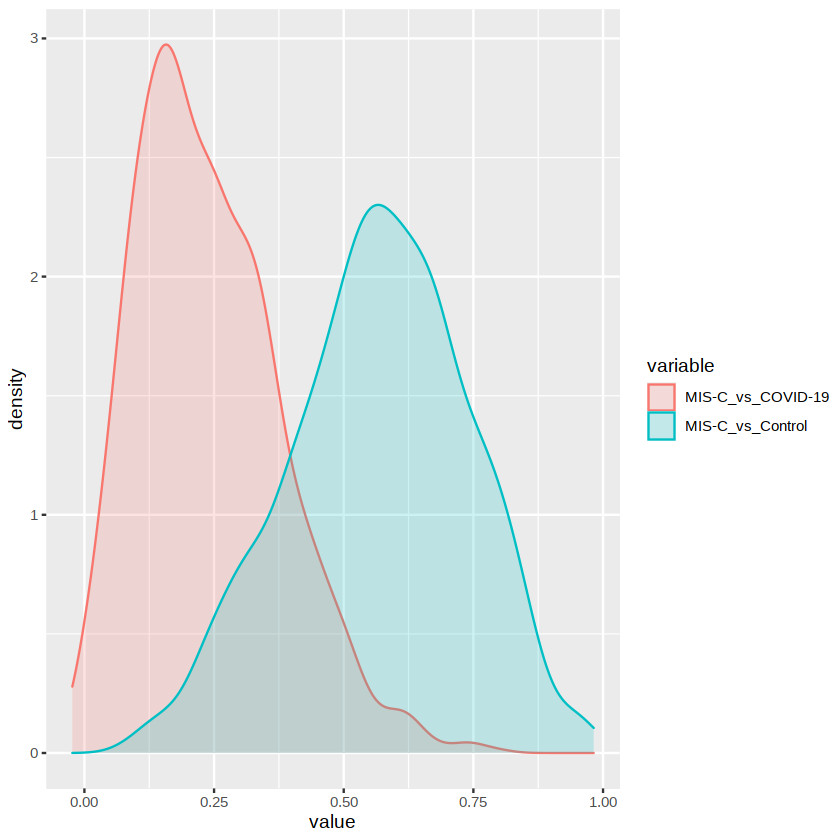

In [7]:
sim_df_m %>% 
    ggplot(aes(x=value,color=variable,fill=variable)) + 
    geom_density(alpha = 0.2) 